
 forma dataframe con index similares
WRF (14060, 5)
OBS (14060, 5)

 forma dataframe con index similares y sin valores nan
WRF (13775, 5)
OBS (13775, 5)

 T2
RMSE Func. T2 :   2.115920084651041
BIAS  T2 :   0.24478819183515765




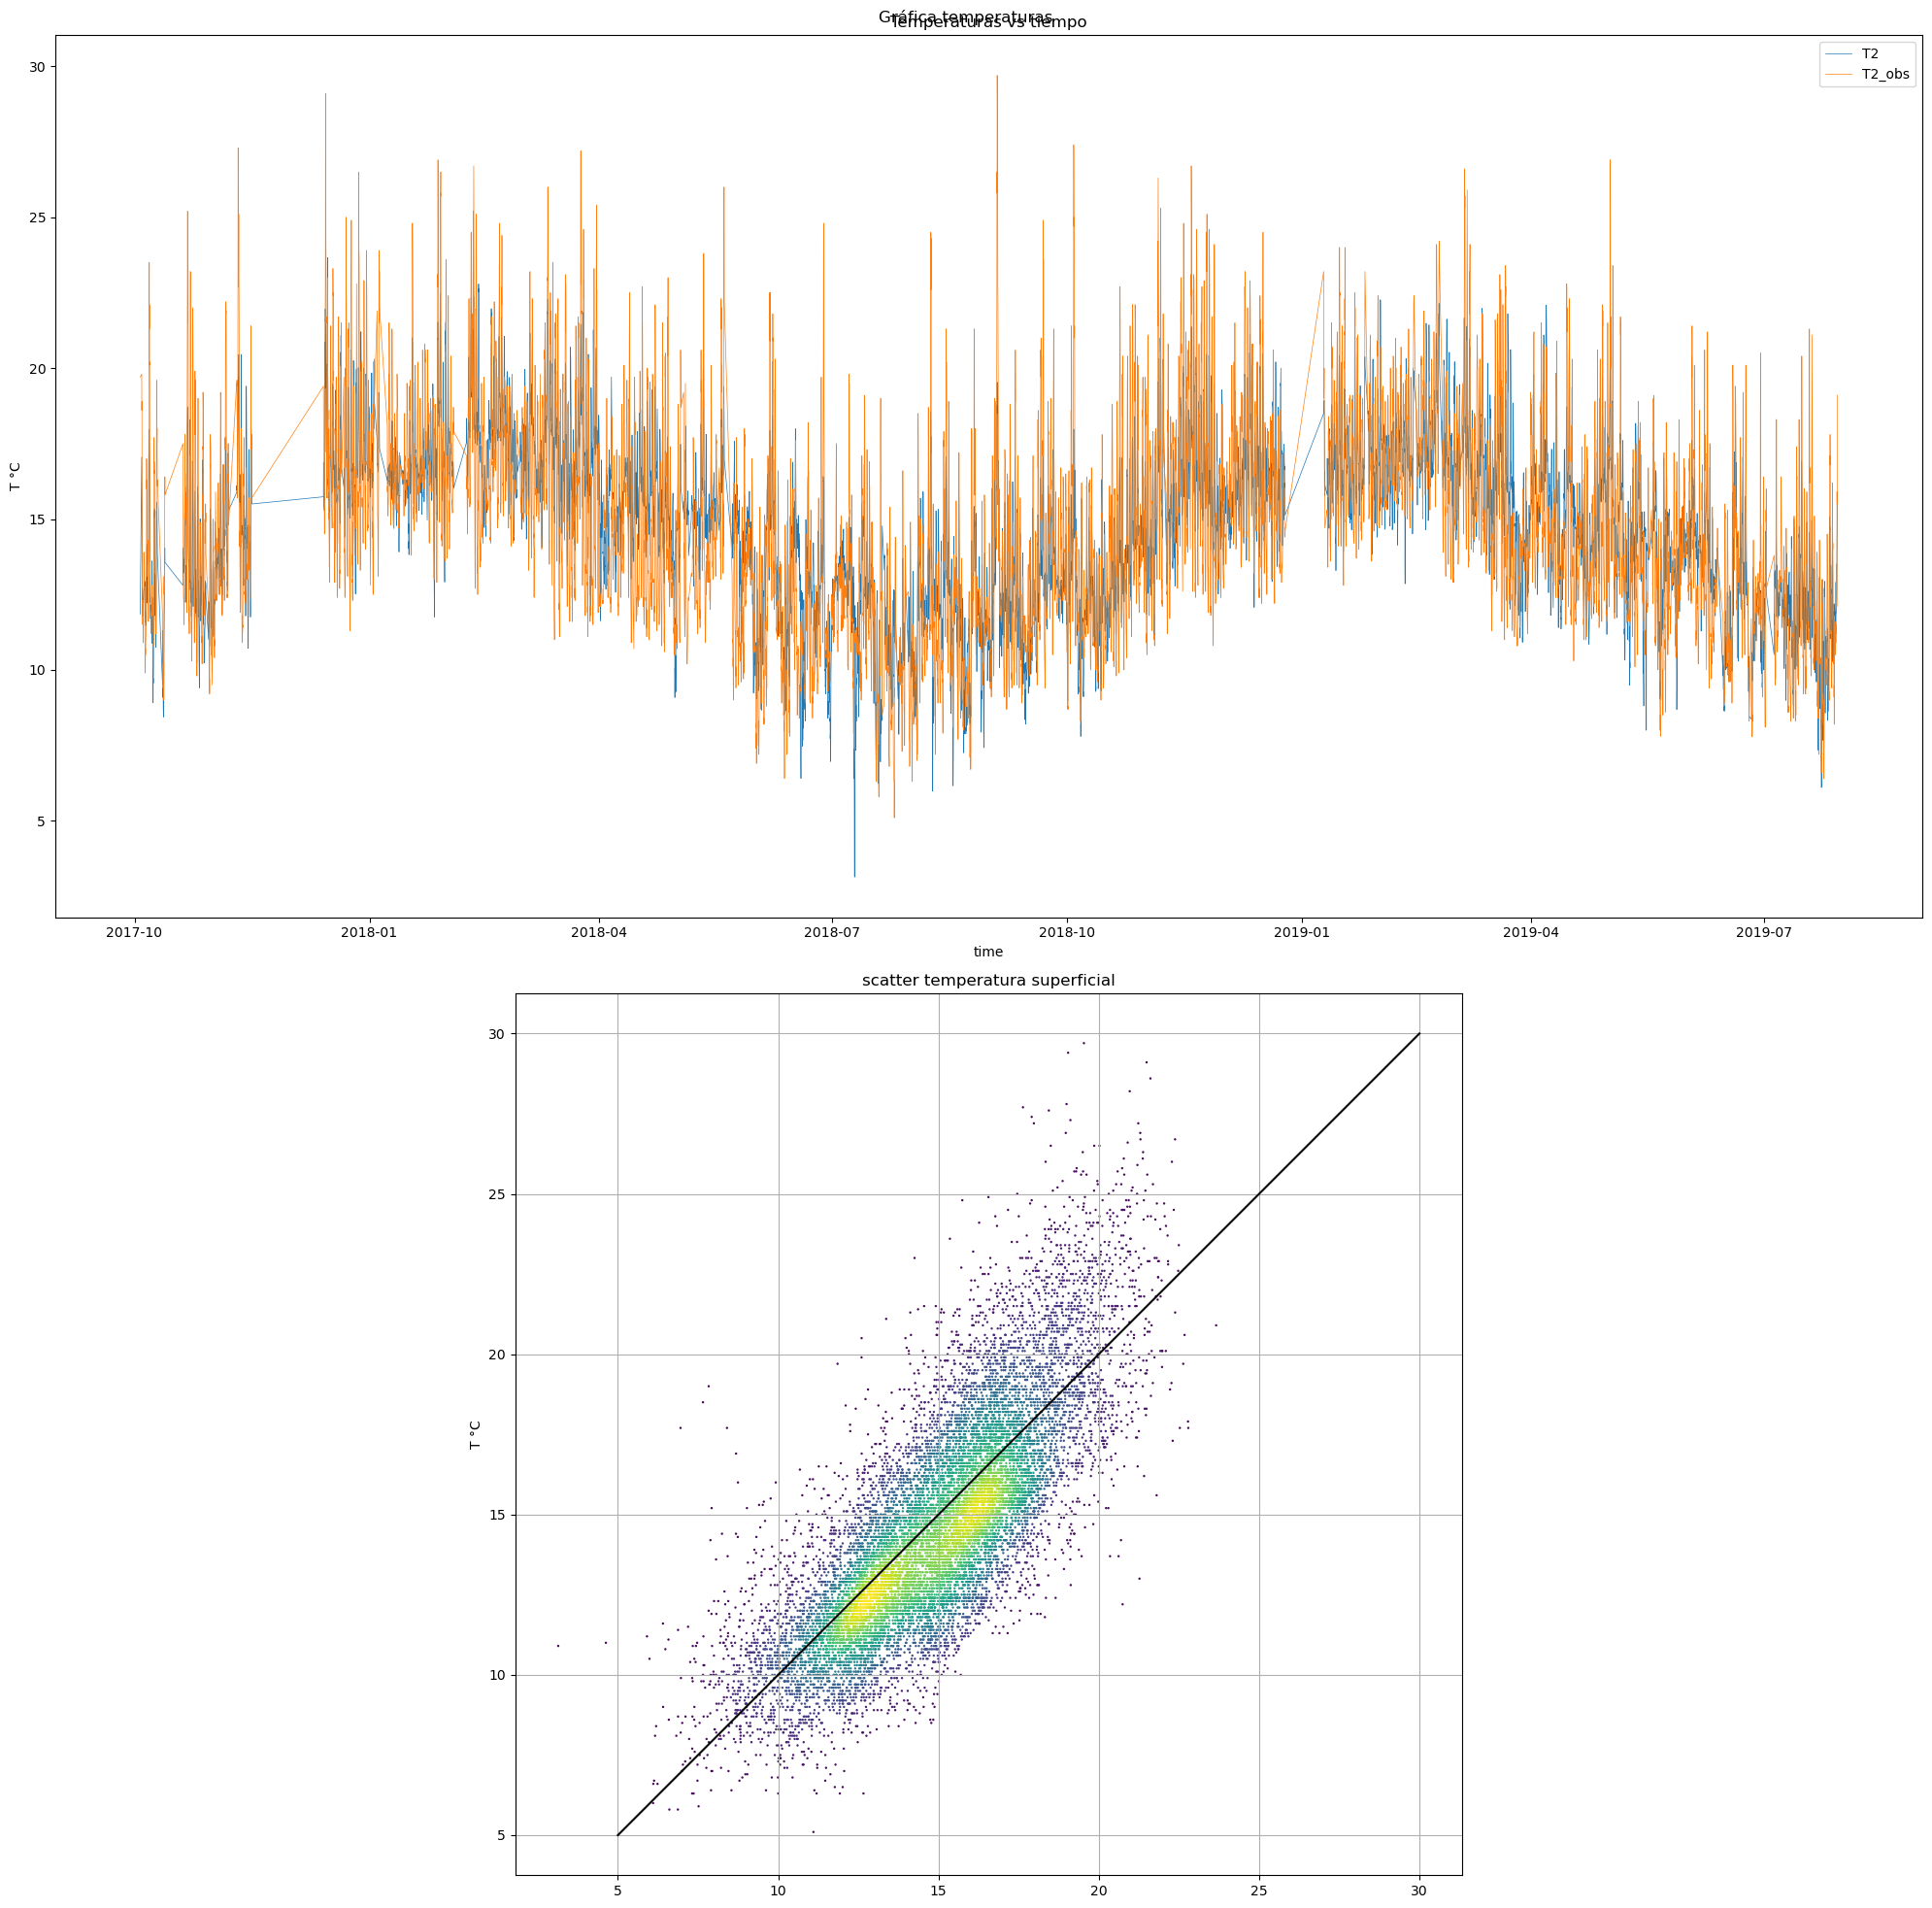


 rh2
RMSE Func. rh2 :   22.47097086522696
BIAS  rh2 :   9.944115839367987




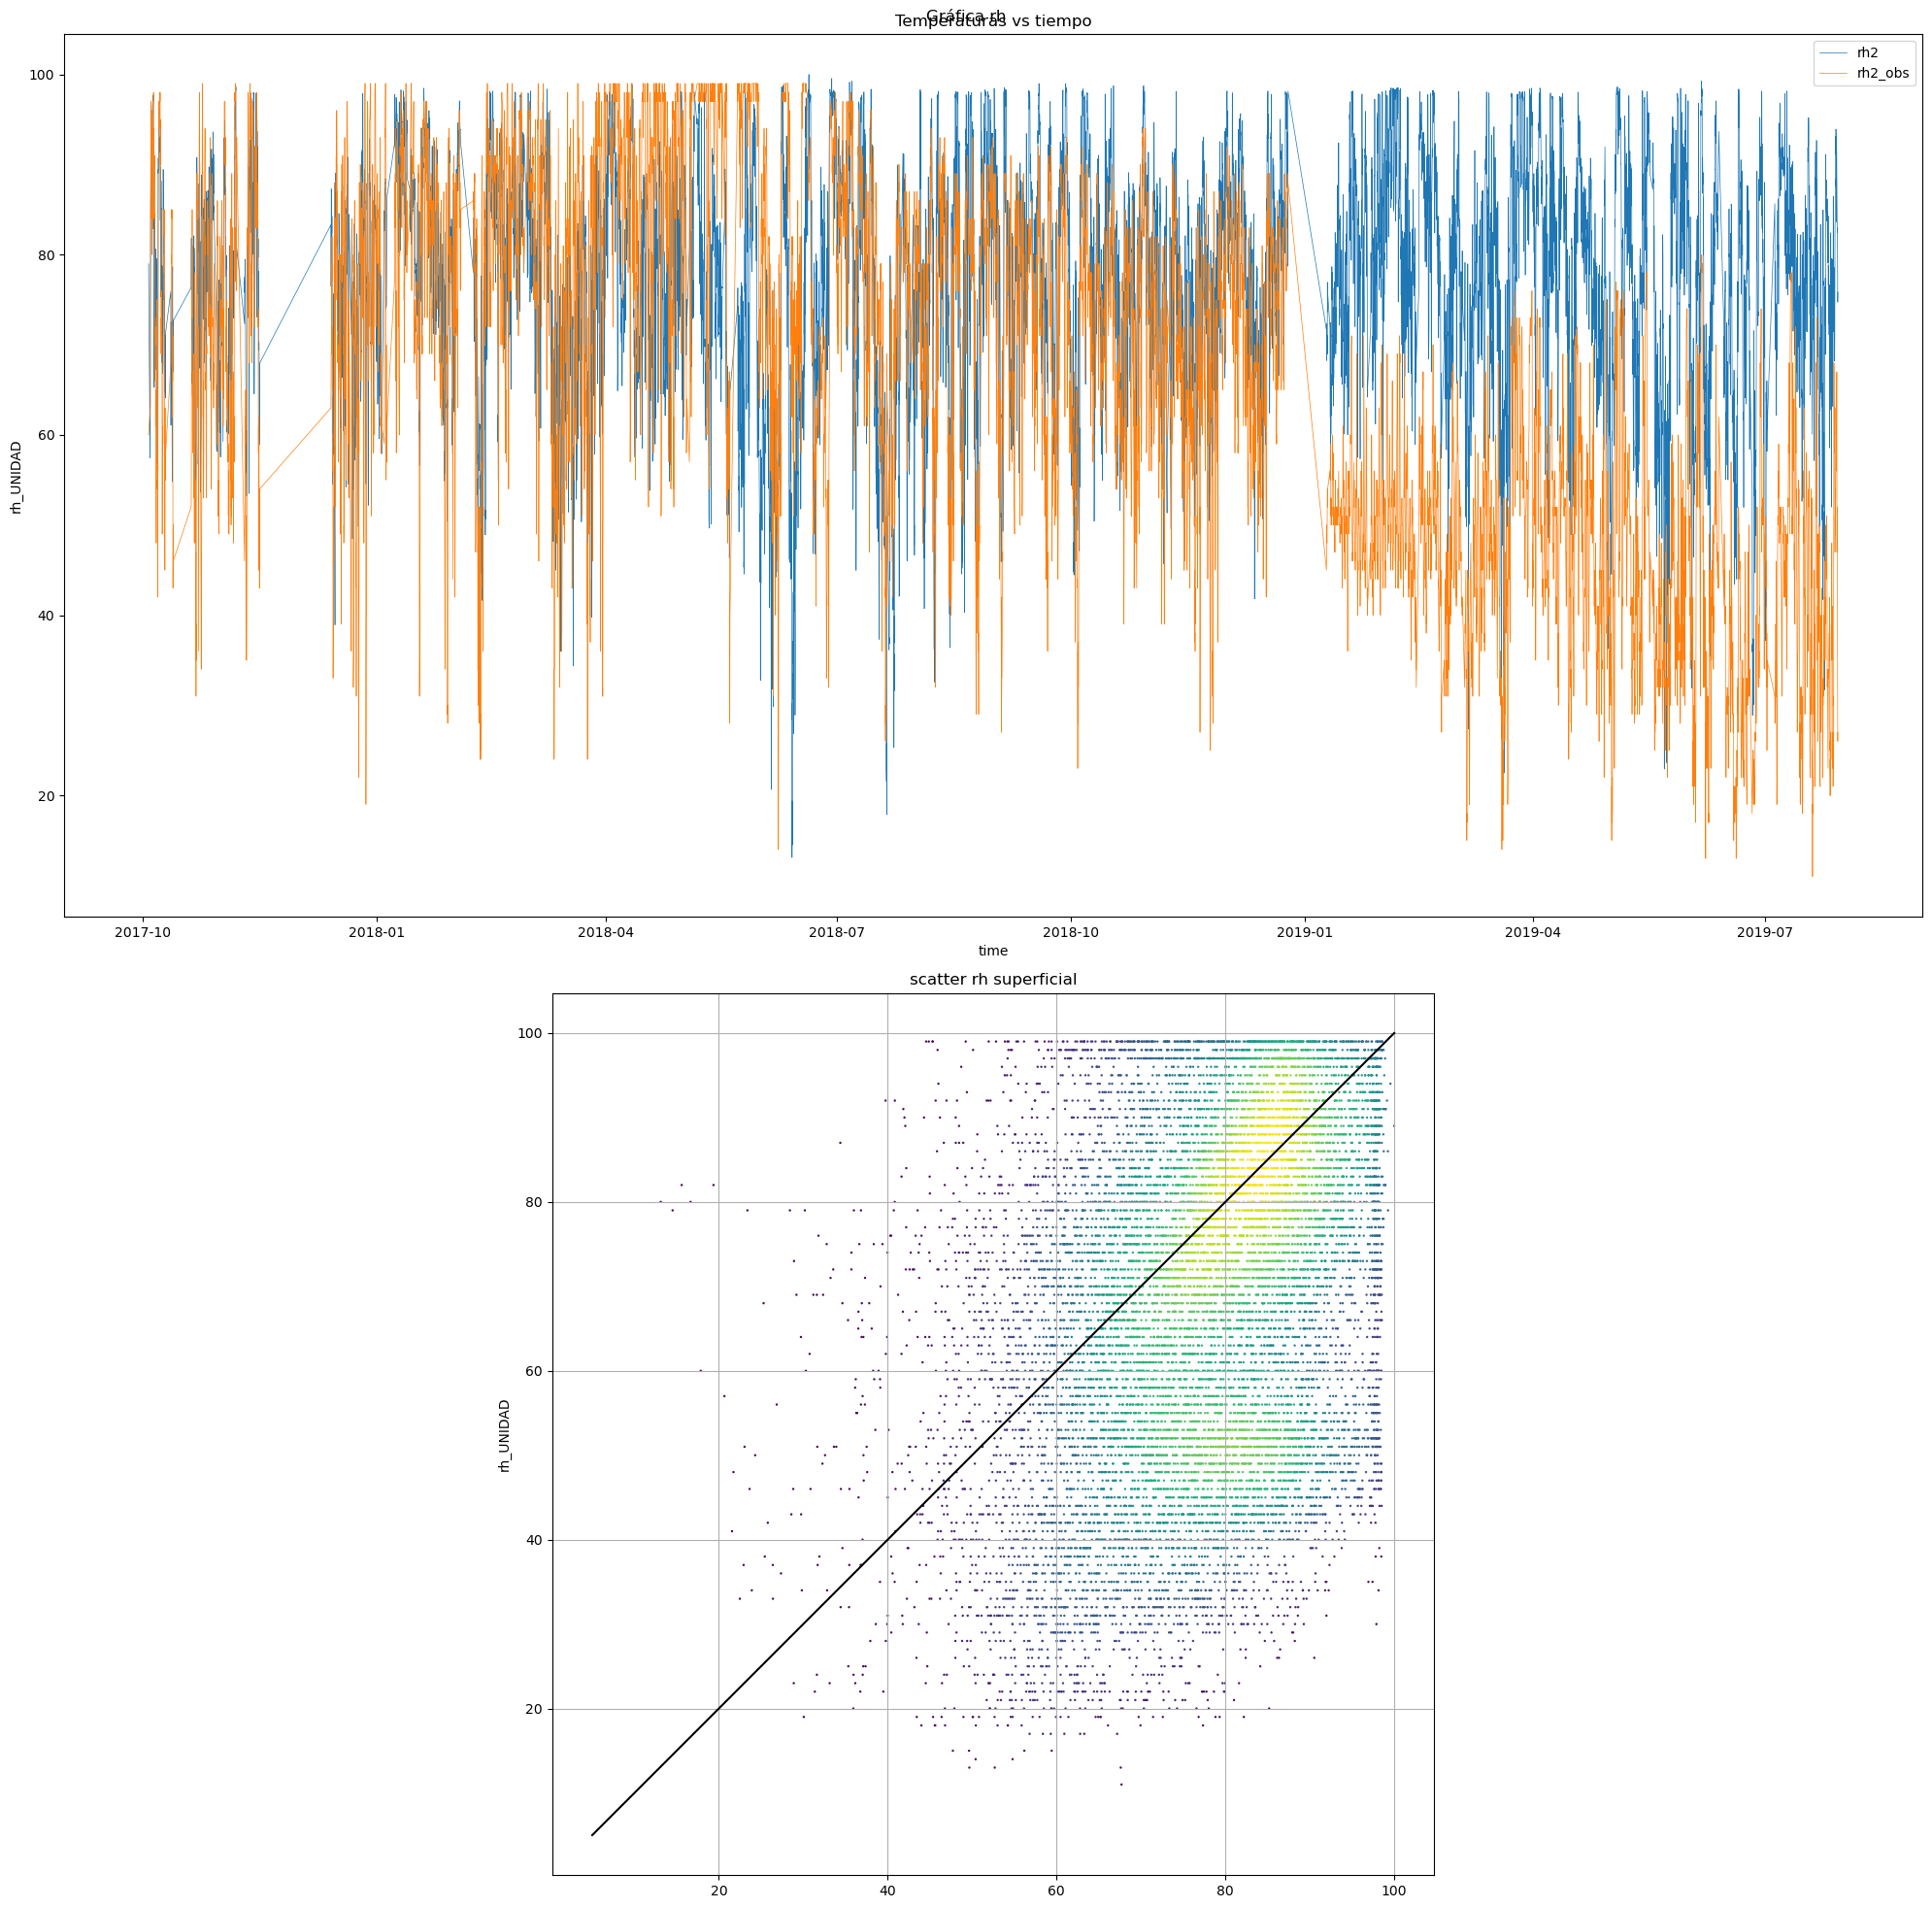


 ws10
RMSE Func. ws10 :   2.4619820963386756
BIAS  ws10 :   1.1718715685805585




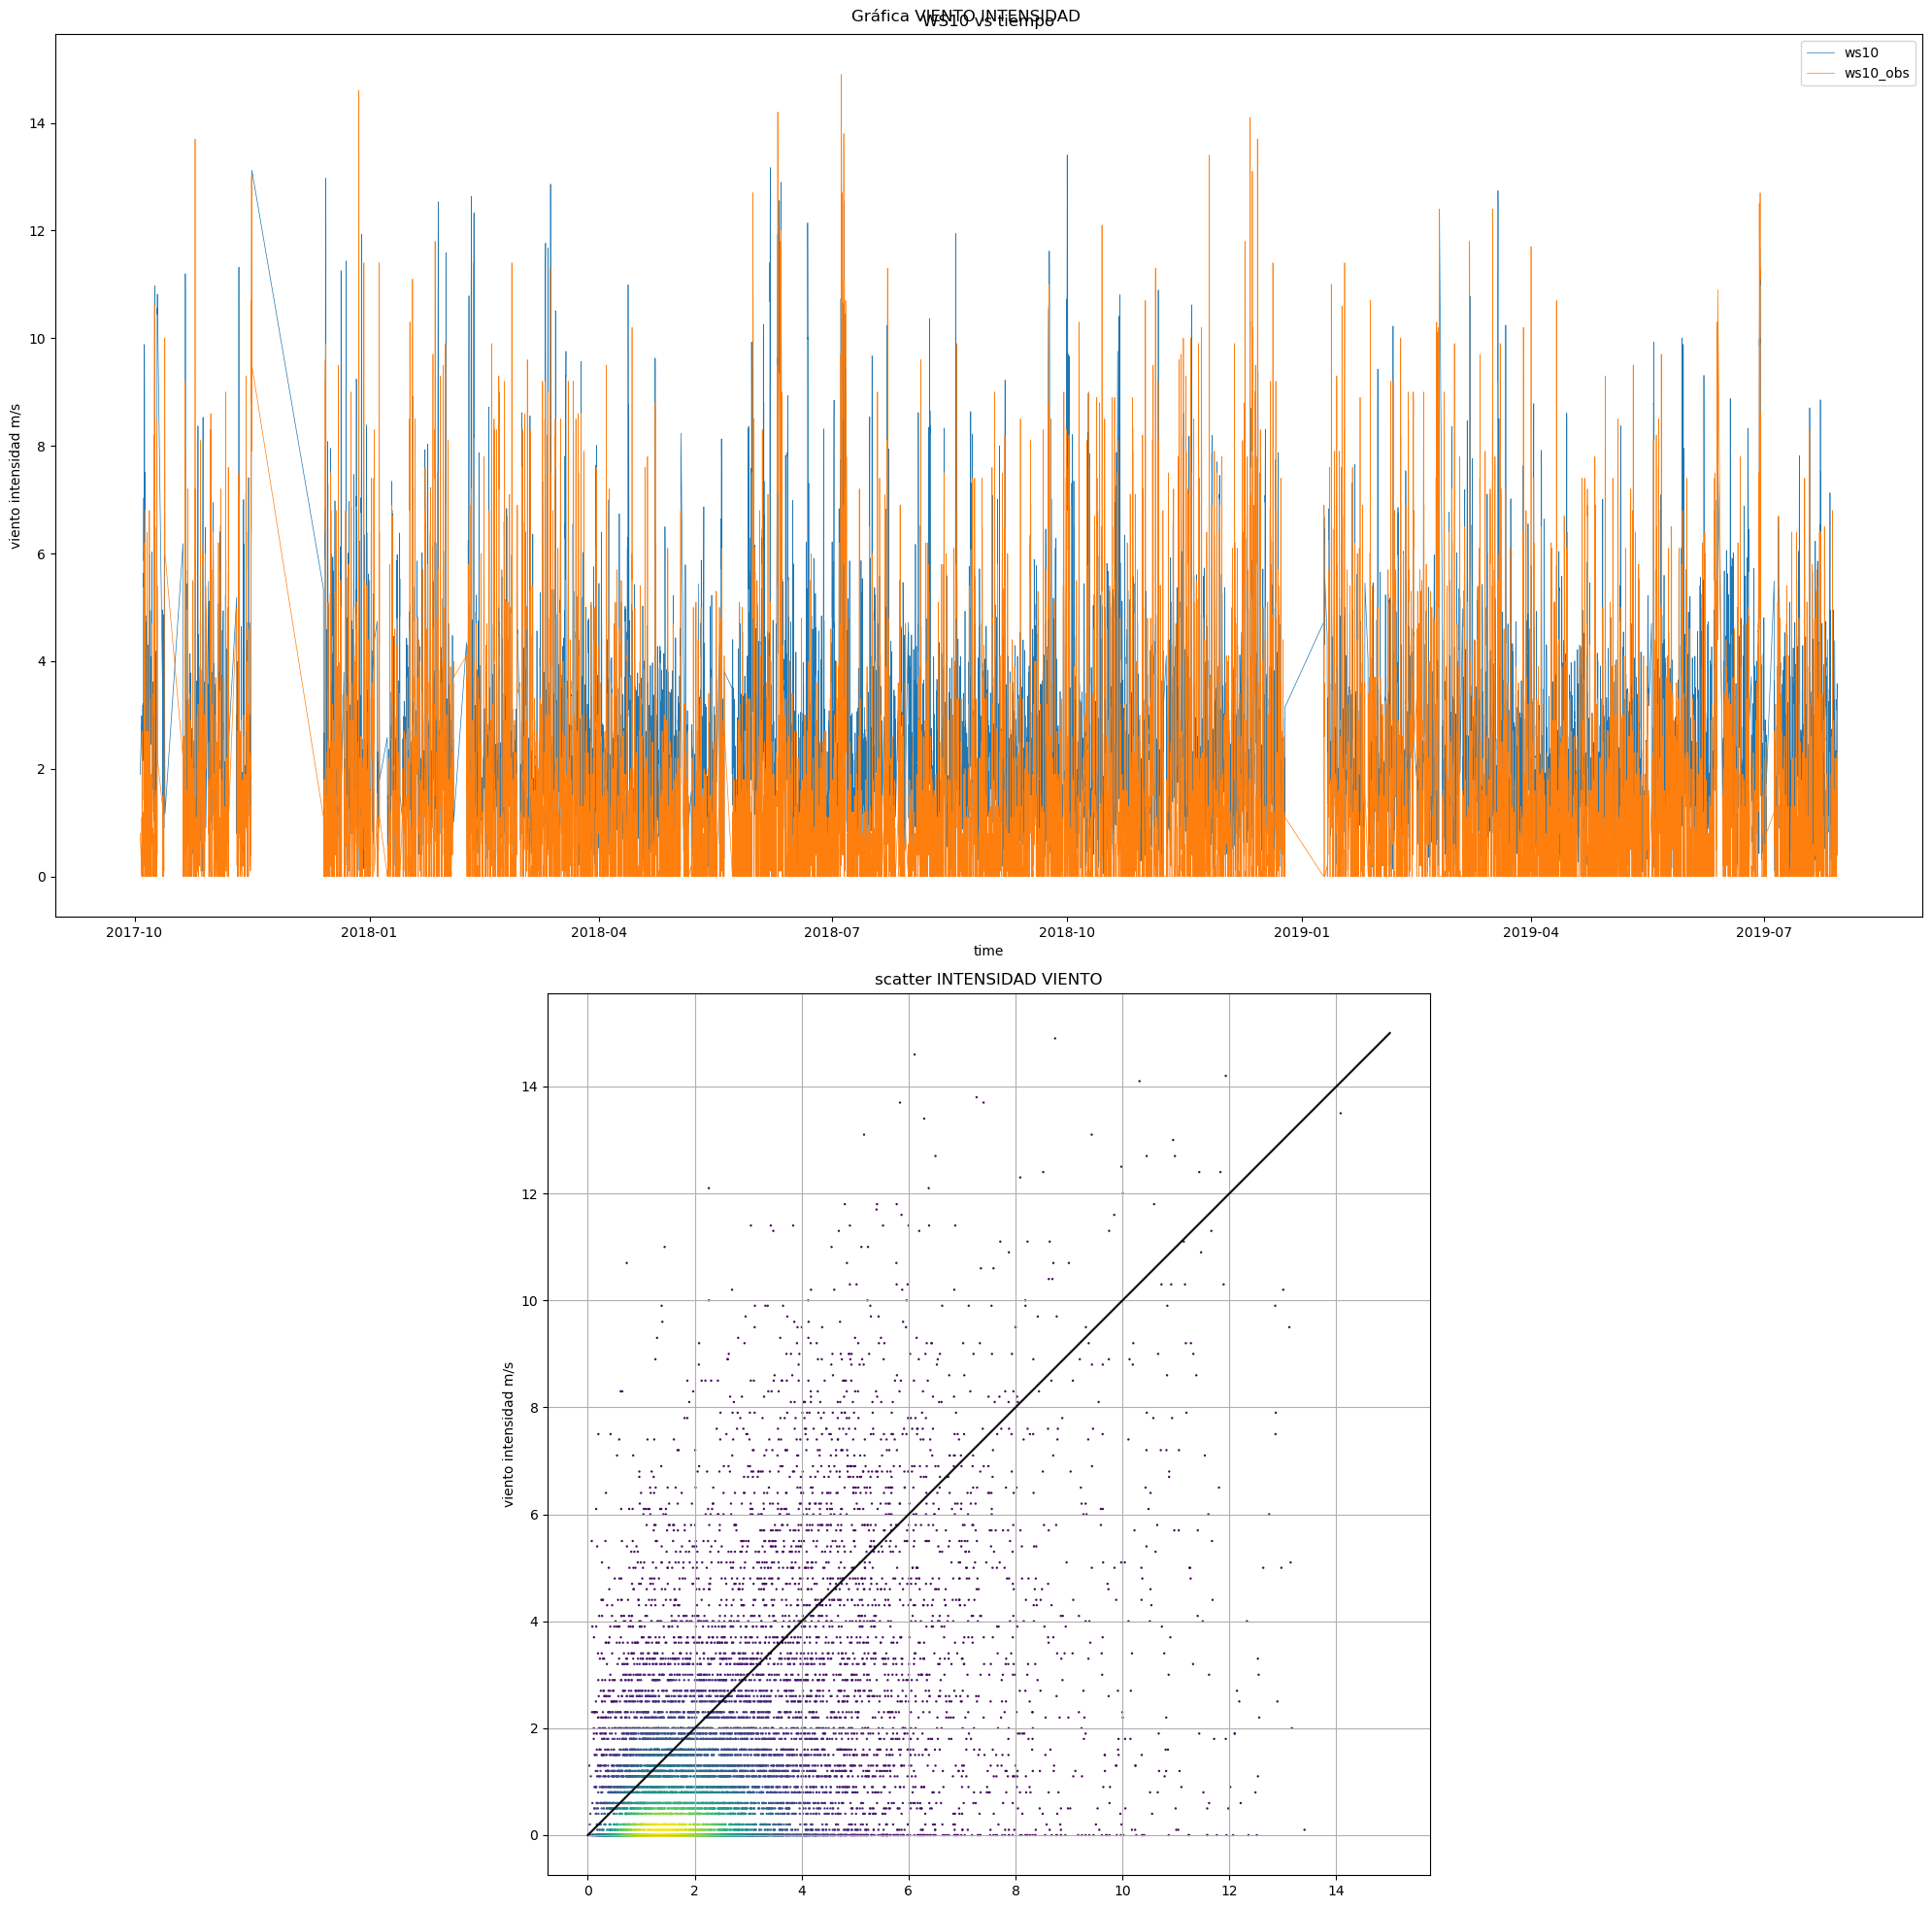

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from scipy.optimize import curve_fit





############################### FUNCIONES ##################
######## funcion para analisar contenido de dataframe
def analisis_df(df):
    columna = df.columns
    index_type = df.index.__class__.__name__
    index_range = (df.index[0], df.index[-1])
    num_data_por_columna = df.count()
    num_nan_por_columna = df.isnull().sum()

    analisis_df = pd.DataFrame({
        'Columnas': columna,
        'Tipo de Índice': index_type,
        'Rango de Índice': [index_range] * len(columna),
        'Número de Datos': num_data_por_columna,
        'Número de NaN': num_nan_por_columna
    })
    
    return analisis_df

#STAT function

def rm(m,o):
        rm= (np.nanmean((m-o) ** 2)) ** 0.5
        return rm #(round(rm,2))

def bi(m,o):
        bias= (np.nanmean(m-o))
        return bias #(round(bias,2))

#################################################################
################################### correcciones al formato de los archivos de datos


# Cargar los datos de los archivos PKL en DataFrames
path0 = 'meteo-2017-21019_por-hora_formato.csv'
path1 = 'Weather_pronostico_1dia.pkl'
path2 = 'Weather_pronostico_2dia.pkl'
path3 = 'Weather_pronostico_3dia.pkl'

df_obs = pd.read_csv(path0)
df_wrf = pd.read_pickle(path1)

### correcciones de formato para los indices de cada dataframe
df_obs.index =df_obs['Unnamed: 0']
df_obs.index = pd.to_datetime(df_obs.index)
df_wrf.index = df_wrf.index.round('H')
#correccion unidad T2, de kelvin a celcius
df_wrf['T2']=df_wrf['T2']-273.16

### reagrupamos los dataframe para el mismo rango de tiempo

# Definir el rango de tiempo deseado
fecha_inicio = '2017-10-03 06:00:00'
fecha_fin = '2019-07-29 19:00:00'

df_wrf2=df_wrf
df_wrf = df_wrf[fecha_inicio:fecha_fin]

# reagrupamos para las columnas de interes en un mismo orden.
columnas_interes = ['td', 'rh_out', 't_out','wind', 'wind_dir']
df_obs =df_obs[columnas_interes]

# Renombrar las columnas
nuevos_nombres = {'td': 'td2_obs', 'rh_out': 'rh2_obs', 't_out': 'T2_obs','wind':'ws10_obs', 'wind_dir': 'wd10_obs'}
df_obs.rename(columns=nuevos_nombres, inplace=True)
df_obs = df_obs.rename_axis('time')

################################################################
#### reagrupamos los data frame correspondiendo los indices, y comparando solo para valores numericos (no nan)

df_wrf2=df_wrf2[df_wrf2.index.isin(df_obs.index)]
df_obs2=df_obs[df_obs.index.isin(df_wrf2.index)]
print('\n forma dataframe con index similares')
print("WRF",df_wrf2.shape)
print("OBS",df_obs2.shape)
ix1=~np.isnan(df_obs2['T2_obs']) & ~np.isnan(df_wrf2['T2'])

df_obs2=(df_obs2[ix1])
df_wrf2=(df_wrf2[ix1])

print('\n forma dataframe con index similares y sin valores nan')
print("WRF",df_wrf2.shape)
print("OBS",df_obs2.shape)

    
#################### analisis del contenido de cada dataframe 

analisis_resultado1 = analisis_df(df_obs2)
#print('\n df observado: \n' ,analisis_resultado1)
analisis_resultado2 = analisis_df(df_wrf2)
#print('\n df modelo wfr: \n',analisis_resultado2)

df_common = df_obs2.join(df_wrf2)
#print(df_common)


#############################################################################
######################### comparacion para cada varialble ###################
variables = ['T2','rh2', 'ws10']#,'wd10']  

############################
###### TEMPERATURA ######################
########################
var = 'T2'
unidad = 'T °C'


df = df_common[[var, var + '_obs']].dropna()
values = df[[var, var + '_obs']].values.T

############ promedios y densidad de probabilidad para T2

densidad = gaussian_kde(values)(values)
#print(densidad)

print('\n',var)
print("RMSE Func.",var, ":  ",rm(df[var],df[var + '_obs']))
print("BIAS ",var, ":  ",bi(df[var],df[var + '_obs']))
print('\n')


############# graficas para temperatura

fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 20))  # Comparte el eje x
fig.suptitle('Gráfica temperaturas')

ax1.plot(df[var], label=var,linewidth=0.5)
ax1.plot(df[var + '_obs'], label=var + '_obs',linewidth=0.5)
ax1.set_title('Temperaturas vs tiempo')
ax1.set_ylabel(unidad)
ax1.set_xlabel('time')
ax1.legend()  
  

ax2.scatter(df[var], df[var + '_obs'], c=densidad, s=0.5)
ax2.plot([5,30],[5,30],'k')
ax2.set_title('scatter temperatura superficial')
ax2.set_ylabel(unidad)
ax2.set_aspect('equal', adjustable='box')
ax2.grid(True)

plt.tight_layout()  # Ajustar automáticamente el diseño para evitar superposiciones
plt.show()
######################################################

############################
###### HUMEDAD RELATIVA ######################
########################

var = 'rh2'
unidad = 'rh_UNIDAD'

df = df_common[[var, var + '_obs']].dropna()
values = df[[var, var + '_obs']].values.T

############ promedios y densidad de probabilidad para rh2

densidad = gaussian_kde(values)(values)
#print(densidad)

print('\n',var)
print("RMSE Func.",var, ":  ",rm(df[var],df[var + '_obs']))
print("BIAS ",var, ":  ",bi(df[var],df[var + '_obs']))
print('\n')

################ graficas rh

fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 20))  # Comparte el eje x
fig.suptitle('Gráfica rh')

ax1.plot(df[var], label=var,linewidth=0.5)
ax1.plot(df[var + '_obs'], label=var + '_obs',linewidth=0.5)
ax1.set_title('Temperaturas vs tiempo')
ax1.set_ylabel(unidad)
ax1.set_xlabel('time')
ax1.legend()  
  

ax2.scatter(df[var], df[var + '_obs'], c=densidad, s=0.5)
ax2.plot([5,100],[5,100],'k')
ax2.set_title('scatter rh superficial')
ax2.set_ylabel(unidad)
ax2.set_aspect('equal', adjustable='box')
ax2.grid(True)

plt.tight_layout()  # Ajustar automáticamente el diseño para evitar superposiciones
plt.show()
######################################################

############################
###### VIENTO INTENSIDAD ######################
########################
var = 'ws10'
unidad = 'viento intensidad m/s'


df = df_common[[var, var + '_obs']].dropna()
values = df[[var, var + '_obs']].values.T

############ promedios y densidad de probabilidad para T2

densidad = gaussian_kde(values)(values)
#print(densidad)

print('\n',var)
print("RMSE Func.",var, ":  ",rm(df[var],df[var + '_obs']))
print("BIAS ",var, ":  ",bi(df[var],df[var + '_obs']))
print('\n')

############# graficas para temperatura

fig, (ax1, ax2) = plt.subplots(2, figsize=(20, 20))  # Comparte el eje x
fig.suptitle('Gráfica VIENTO INTENSIDAD')

ax1.plot(df[var], label=var,linewidth=0.5)
ax1.plot(df[var + '_obs'], label=var + '_obs',linewidth=0.5)
ax1.set_title('WS10 vs tiempo')
ax1.set_ylabel(unidad)
ax1.set_xlabel('time')
ax1.legend()  
  

ax2.scatter(df[var], df[var + '_obs'], c=densidad, s=0.5)
ax2.plot([0,15],[0,15],'k')
ax2.set_title('scatter INTENSIDAD VIENTO')
ax2.set_ylabel(unidad)
ax2.set_aspect('equal', adjustable='box')
ax2.grid(True)

plt.tight_layout()  # Ajustar automáticamente el diseño para evitar superposiciones
plt.show()
######################################################
